In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

In [2]:
"""Constants"""

DT = 1
N_PARALLEL = 1000

In [3]:
'''Get datasets, all names'''
import data

DATASETS = data.get_all_data()
ALL_NAMES = data.get_all_names()
print('All identified neurons :\n', ALL_NAMES)

All identified neurons :
 ['AFDL', 'AIBL', 'AIBR', 'ALA', 'ALNL', 'ALNR', 'AS10', 'ASKL', 'ASKR', 'AVAL', 'AVAR', 'AVBL', 'AVBR', 'AVEL', 'AVER', 'AVFL', 'AVFR', 'AWAR', 'AWCL', 'AWCR', 'BAGL', 'BAGR', 'DA01', 'DA07', 'DA09', 'DB01', 'DB02', 'DB07', 'DVA', 'DVB', 'DVC', 'LUAL', 'LUAR', 'OLQDL', 'OLQDR', 'OLQVL', 'OLQVR', 'PDA', 'PHAL', 'PHAR', 'PLML', 'PLMR', 'PVCL', 'PVCR', 'PVCR.1', 'PVNL', 'PVNR', 'RIBL', 'RIBR', 'RID', 'RIFR', 'RIML', 'RIMR', 'RIS', 'RIVL', 'RIVR', 'RMED', 'RMEL', 'RMER', 'RMEV', 'SABD', 'SABVL', 'SABVR', 'SIADL', 'SIADR', 'SIAVL', 'SIAVR', 'SMDDL', 'SMDDR', 'SMDVL', 'SMDVR', 'URADR', 'URAVL', 'URAVR', 'URYDL', 'URYDR', 'URYVL', 'URYVR', 'VA01', 'VA11', 'VA12', 'VB01', 'VB02', 'VB11', 'VD11', 'VD13']


In [4]:
'''Neuron to select'''

NEURON = 'AIBL'

In [5]:
'''Get presynaptic neurons'''

import pylab as plt
import numpy as np

dfs = data.get_synapses()
dfg = data.get_gaps()

gaps = dfg.index[dfg[NEURON] > 0].tolist()
syns = dfs.index[dfs[NEURON] > 0].tolist()
inputs = np.unique(gaps + syns).tolist()
print('Gaps :', gaps)
print('Synapses :', syns)
name_to_nb = {name: nb for nb, name in enumerate(inputs)}
print(name_to_nb)

'''Plot graph'''
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(gaps + syns)
pos = nx.circular_layout(G)
pos[NEURON] = [0,0]
G.add_edges_from([(g, NEURON) for g in gaps])
G.add_edges_from([(g, NEURON) for g in syns])
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, [(g, NEURON) for g in gaps], edge_color='b')
nx.draw_networkx_edges(G, pos, [(g, NEURON) for g in syns], edge_color='r')

plt.axis('off')
plt.draw()

Gaps : ['AFDL', 'DVC', 'RIMR', 'RIVL']
Synapses : ['ASKL', 'AWCL', 'BAGL', 'DVC', 'RIBR', 'RIMR']
{'AFDL': 0, 'ASKL': 1, 'AWCL': 2, 'BAGL': 3, 'DVC': 4, 'RIBR': 5, 'RIMR': 6, 'RIVL': 7}


In [6]:
'''Get datasets with neuron labelled'''

recs = []
max_len = 0
print('Datasets with %s identified : ' % NEURON)
for i, d in enumerate(DATASETS):
    if NEURON in d.columns:
        print(i)
        recs.append(d)
        if len(d) > max_len:
            max_len = len(d)

Datasets with AIBL identified : 
0
1
2
3
4
5


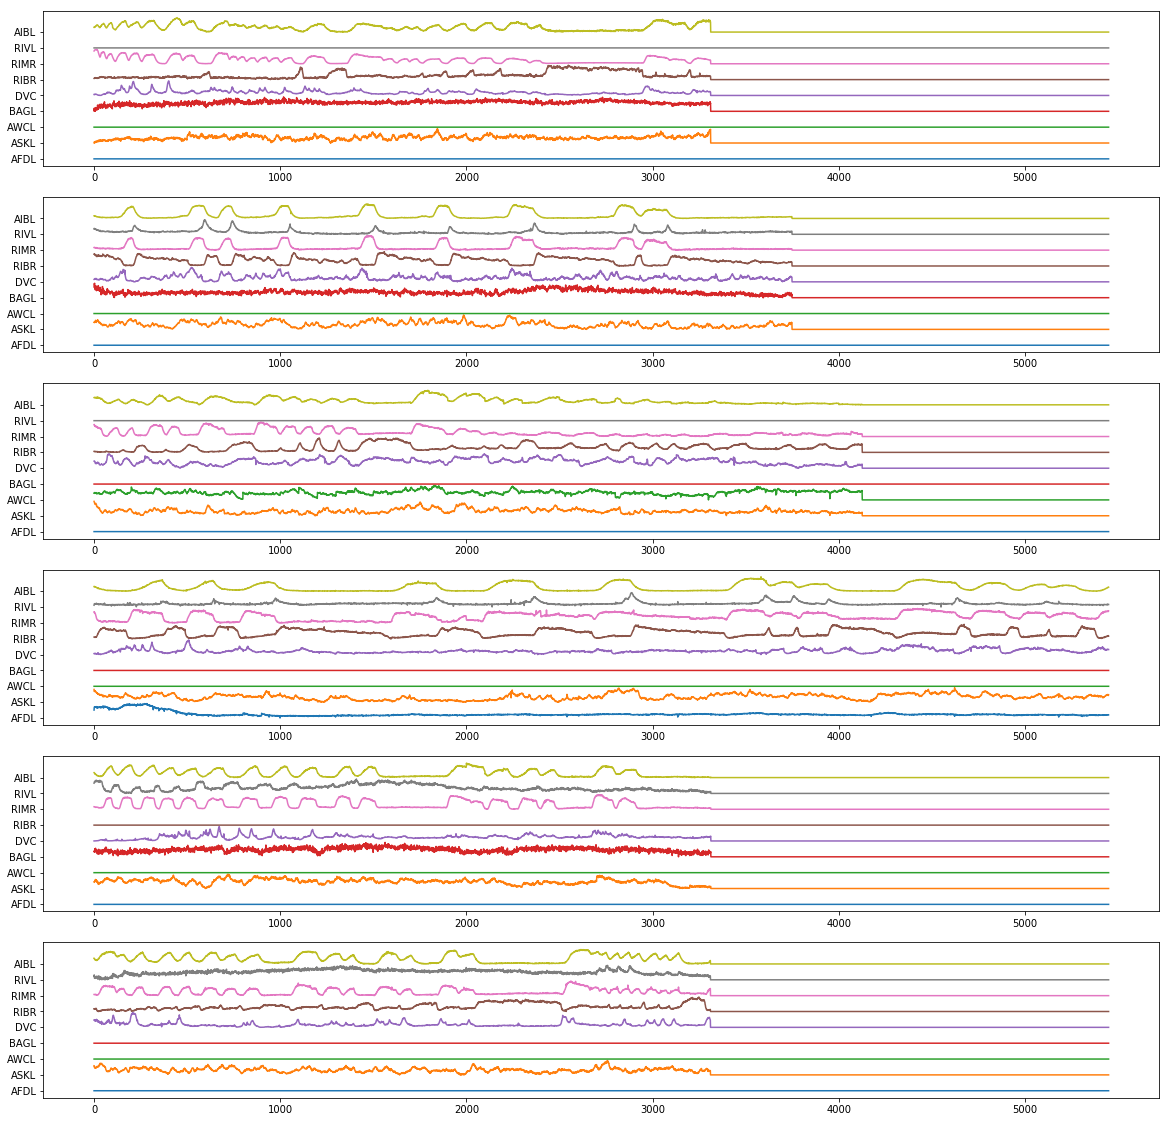

dt :  tensor([[[1.2077]],

        [[1.0670]],

        [[0.9695]],

        [[0.7339]],

        [[1.2074]],

        [[1.2081]]])


In [7]:
'''Collect input traces and initialize dt'''

import numpy as np
import torch

neurons = inputs + [NEURON]
traces = np.zeros((max_len, len(recs), len(neurons)))
dt = torch.zeros(len(recs),1,1)

plt.figure(figsize = (20,20))
for i, rec in enumerate(recs):
    for inp in inputs:
        if inp not in rec.columns:
            rec[inp] = np.zeros(rec.shape[0])
    traces[:rec.shape[0],i] = rec[neurons]
    dt[i] = 4000 / rec.shape[0]
    plt.subplot(len(recs),1,i+1)
    plt.plot(traces[:,i] + [1.1*j for j in range(len(neurons))])
    plt.yticks([1.1*j for j in range(len(neurons))], neurons)

plt.show()
print('dt : ', dt)

In [8]:
'''Define connections'''

conn_g = [(name_to_nb[g], len(inputs)) for g in gaps]
conn_s = [(name_to_nb[s], len(inputs)) for s in syns]

print(conn_g, conn_s)

[(0, 8), (4, 8), (6, 8), (7, 8)] [(1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8)]


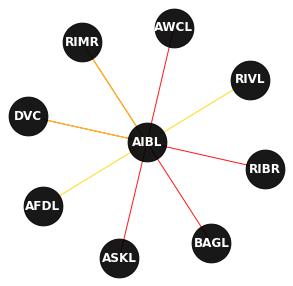

In [9]:
'''Create circuit'''

from odynn.circuit import Circuit
from odynn.models import LeakyIntegrate, ChemSyn, GapJunction

def get_circ(N_parallel = 500, dt=dt):
    n_par = LeakyIntegrate.get_default(len(inputs), N_parallel)
    pout = LeakyIntegrate.get_random(1, N_parallel)
    pn = {k: np.concatenate((n_par[k], pout[k]), 0) for k,v in pout.items()}
    n = LeakyIntegrate(init_p=pn, tensors=True, dt=dt)
    ps = ChemSyn.get_random(len(conn_s),N_parallel)
    ps['E'] = np.repeat([[-1],[0],[0],[1]], N_parallel, axis=-1) + np.random.rand(4,N_parallel) * 0.2
    s = ChemSyn([c[0] for c in conn_s], [c[1] for c in conn_s], 
                              init_p=ps, tensors=True, dt=dt)
    pg = GapJunction.get_random(len(conn_g),N_parallel)
    g = GapJunction([c[0] for c in conn_g], [c[1] for c in conn_g], 
                              init_p=pg, tensors=True, dt=dt)
    return Circuit(n, s, g)


get_circ().plot(labels={i: n for i,n in enumerate(inputs + [NEURON])}, img_size=5)

In [10]:
'''Correlation to initialize E'''

from scipy import stats

correlations = np.zeros((len(syns),1))

for r in range(len(recs)):
    for i in range(len(syns)):
        corr = np.corrcoef(traces[:,r,i], traces[:,r,-1])[0,1]
        if np.isnan(corr):
            corr = 0
        correlations[i] += corr
correlations /= len(recs)
correlations = (correlations + 1) / 2

/home/marc/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/marc/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


  0%|          | 0/701 [00:00<?, ?it/s]

torch.Size([1, 6, 9, 1]) torch.Size([500, 1, 6, 9, 1])
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])
223.99628 101.67203


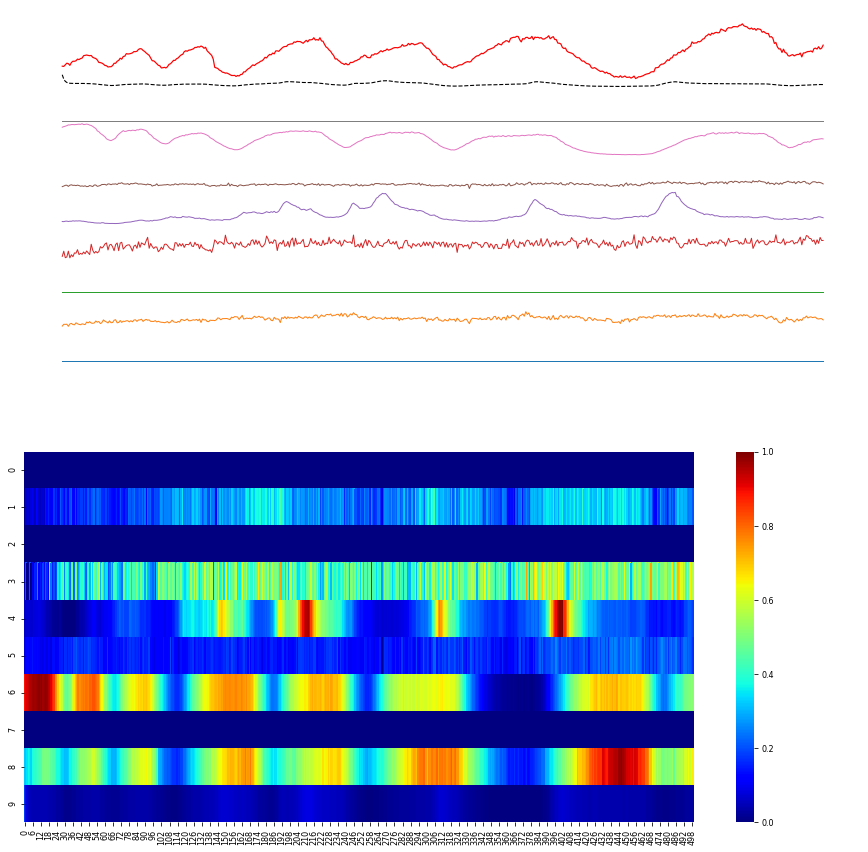

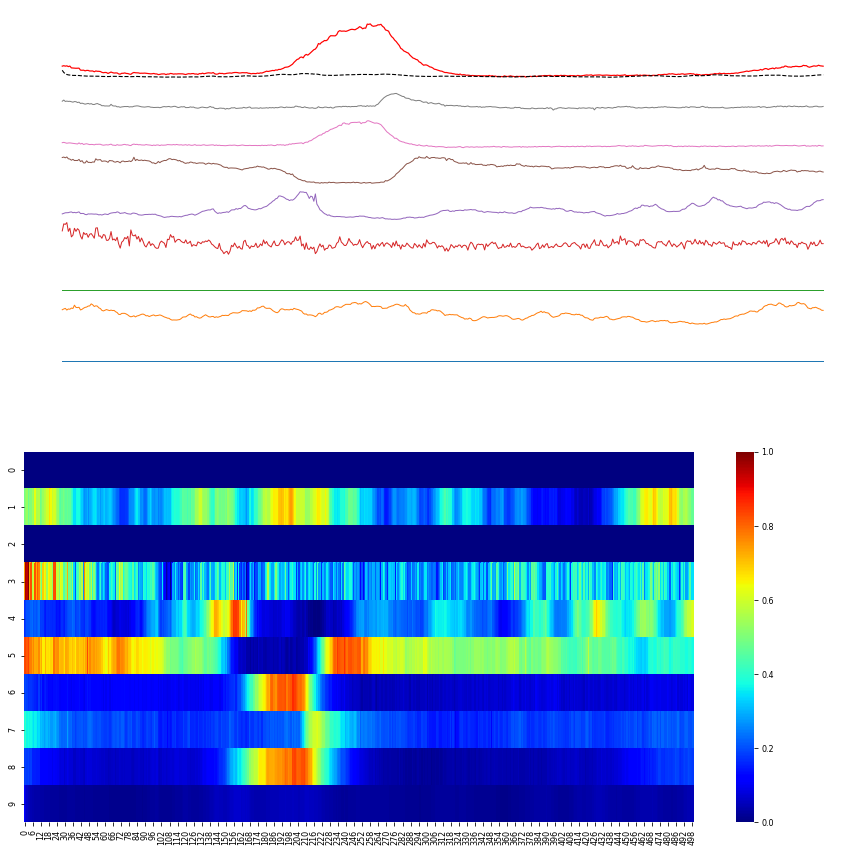

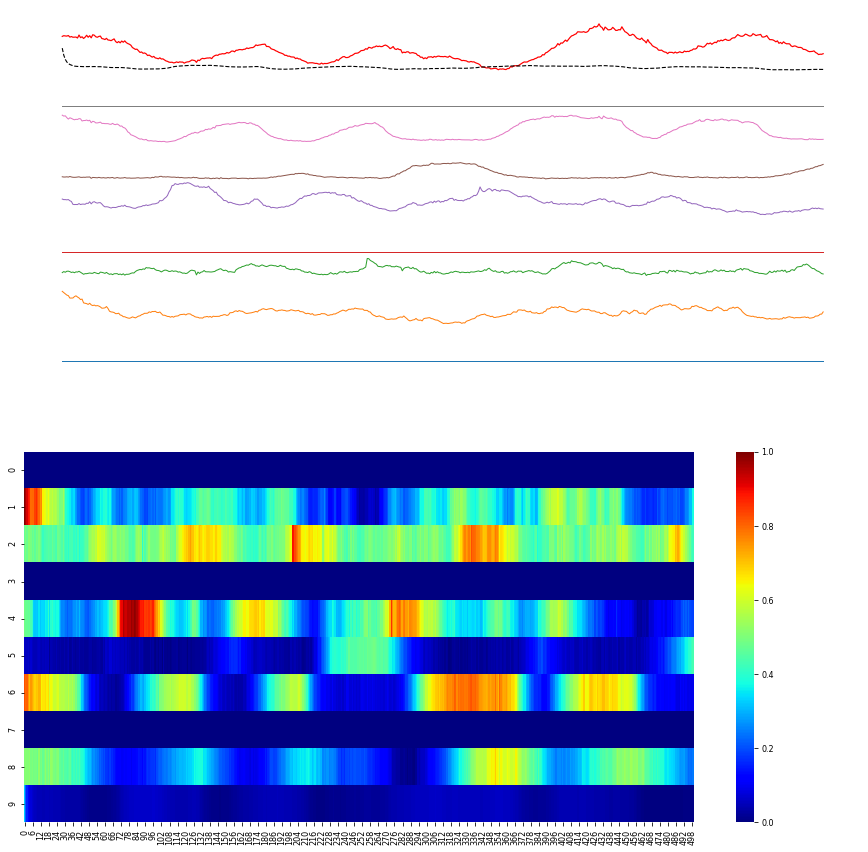

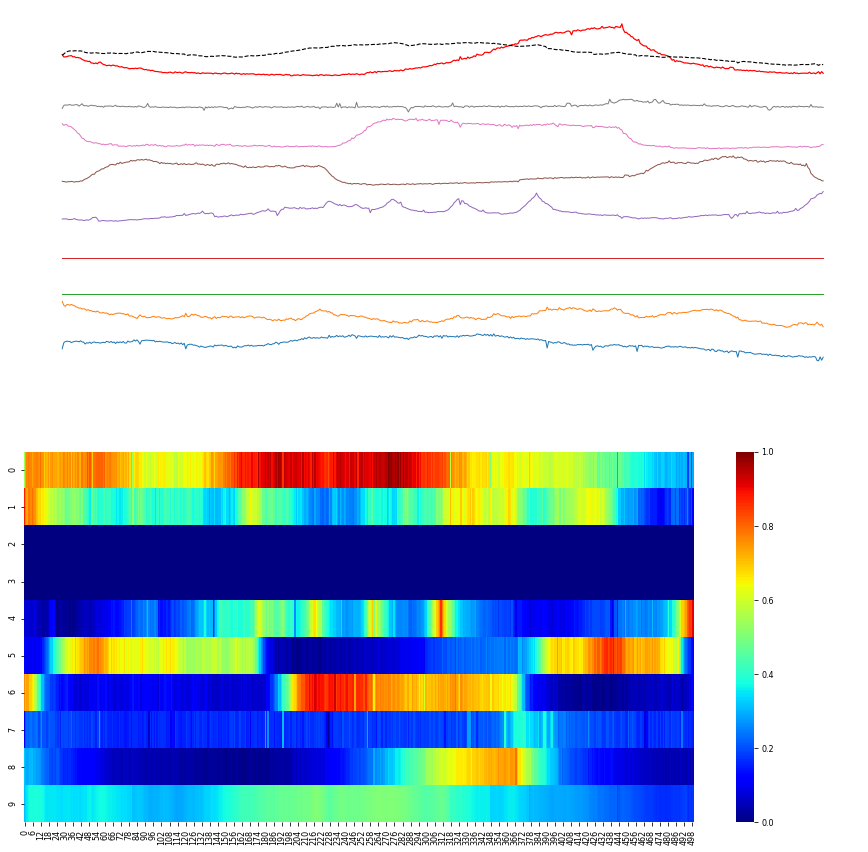

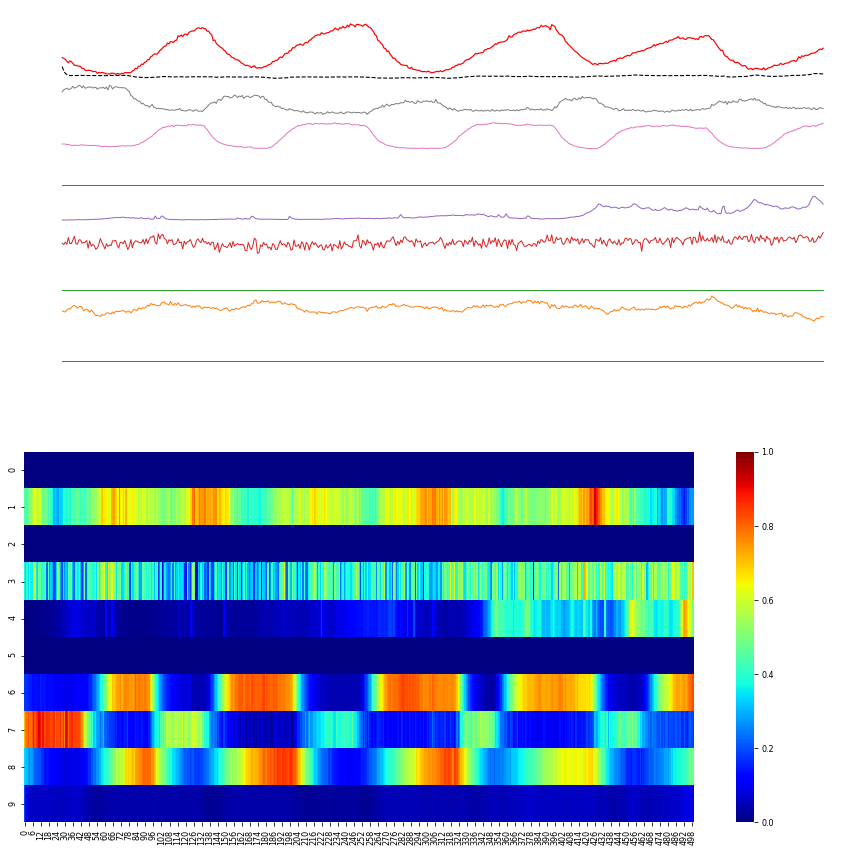

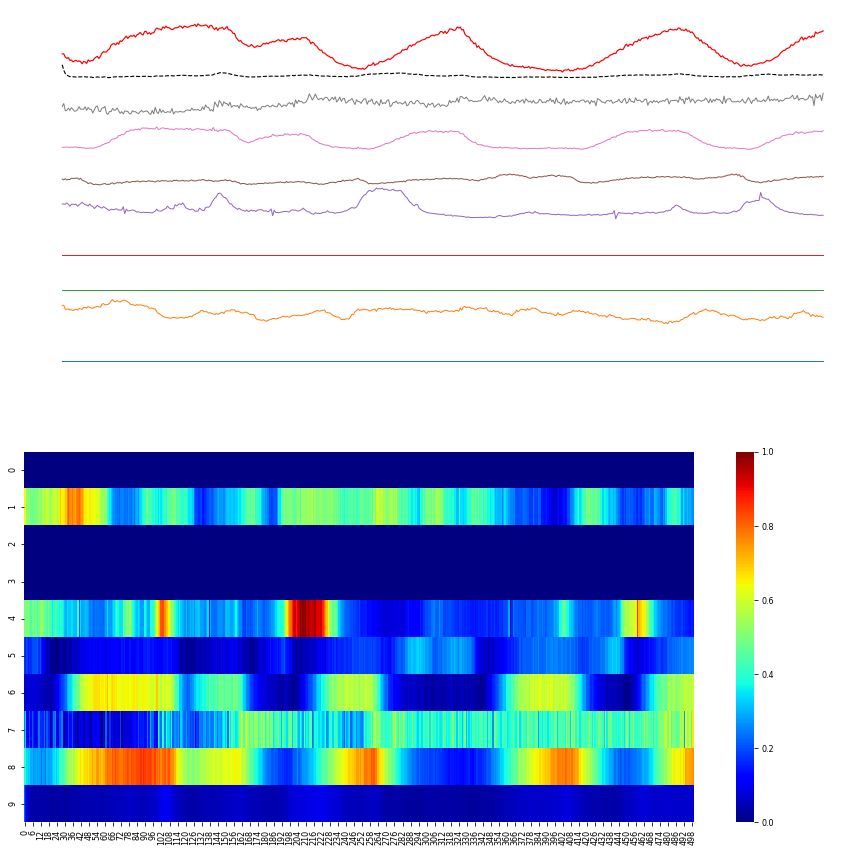

  0%|          | 1/701 [00:10<1:59:40, 10.26s/it]

Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  0%|          | 2/701 [00:14<1:38:36,  8.46s/it]

223.16557 101.46501
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  0%|          | 3/701 [00:18<1:24:27,  7.26s/it]

222.34146 101.25939
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|          | 4/701 [00:23<1:13:22,  6.32s/it]

221.52428 100.975006
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|          | 5/701 [00:27<1:05:35,  5.65s/it]

220.71397 100.55833
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|          | 6/701 [00:31<1:01:42,  5.33s/it]

219.91066 100.149124
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|          | 7/701 [00:35<57:30,  4.97s/it]  

219.11438 99.74738
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|          | 8/701 [00:40<54:54,  4.75s/it]

218.32527 99.35348
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|▏         | 9/701 [00:44<53:56,  4.68s/it]

217.54317 98.96669
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  1%|▏         | 10/701 [00:48<52:37,  4.57s/it]

216.7682 98.5881
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])
216.00034 98.21683


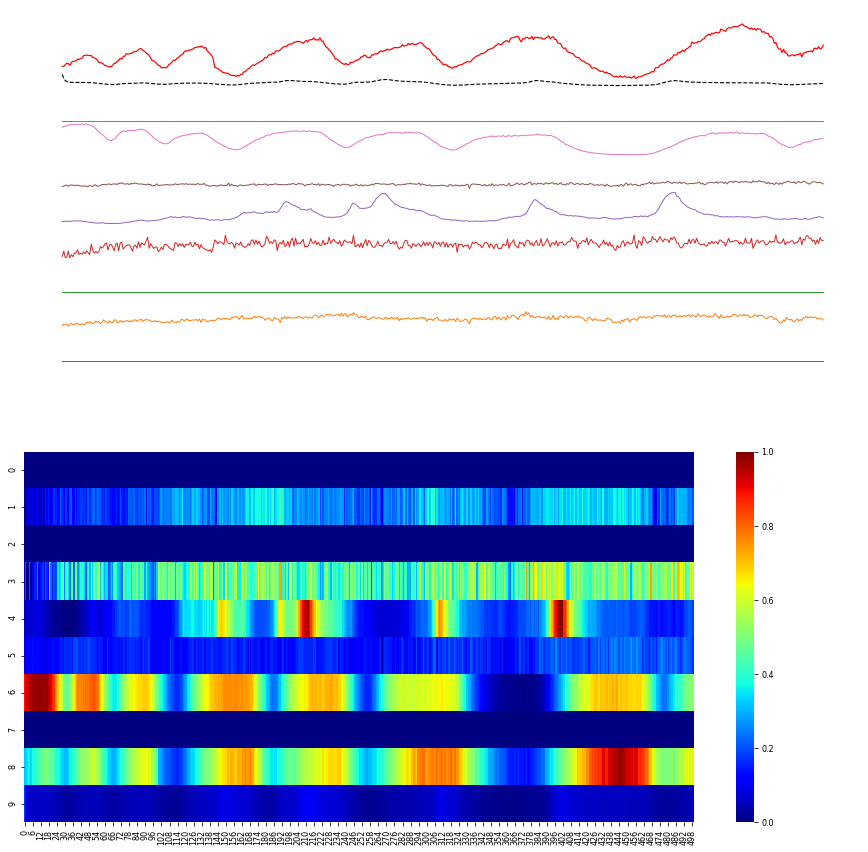

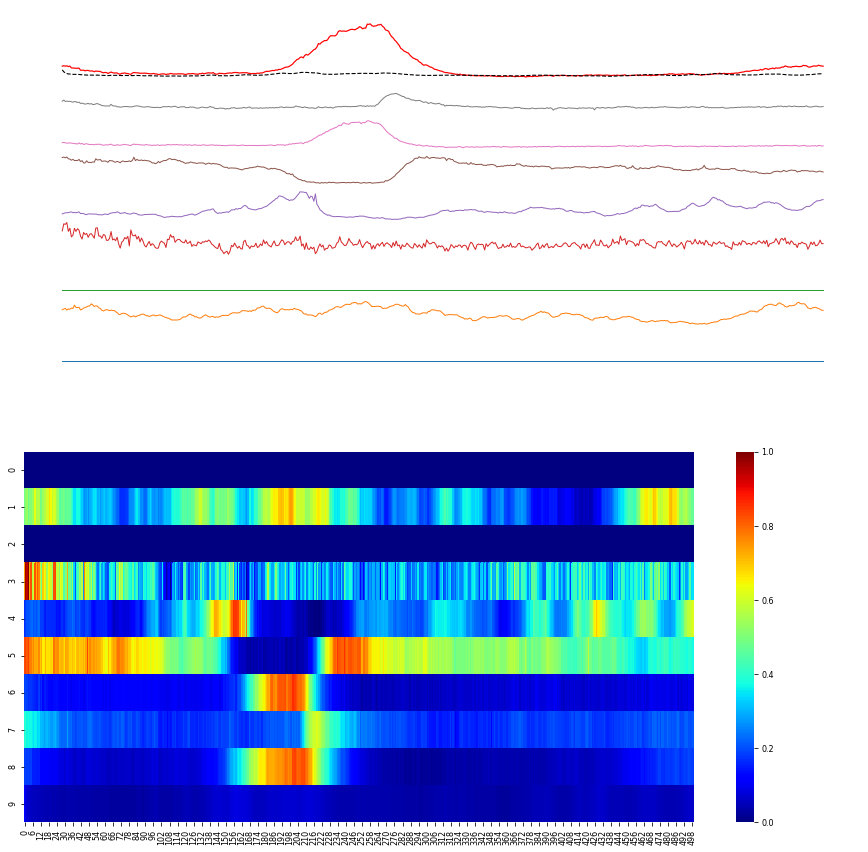

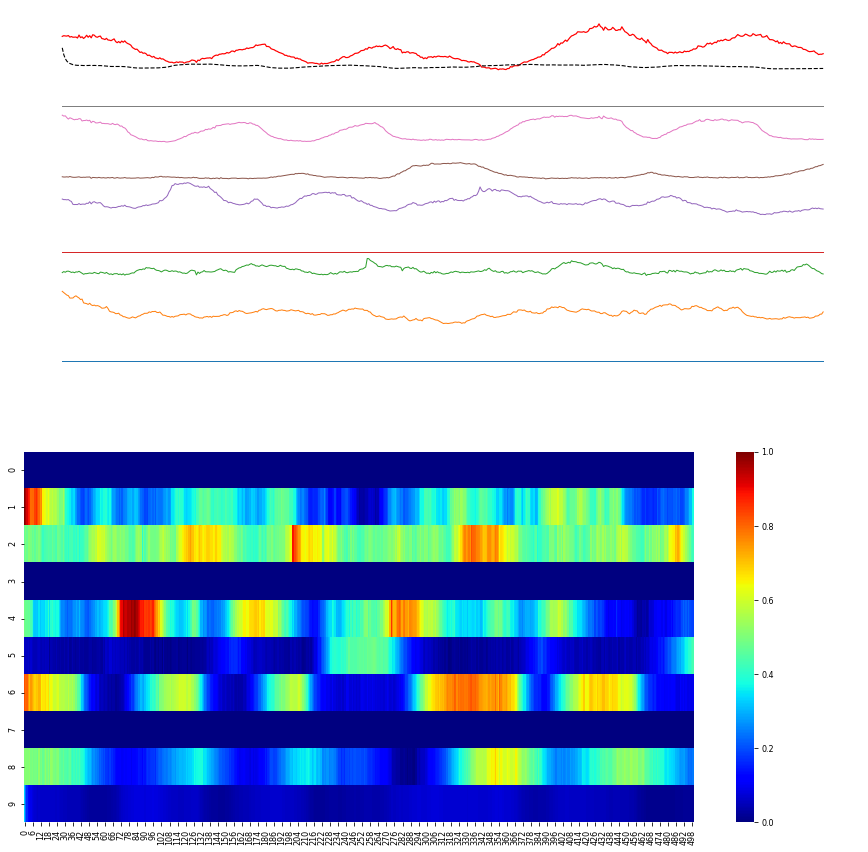

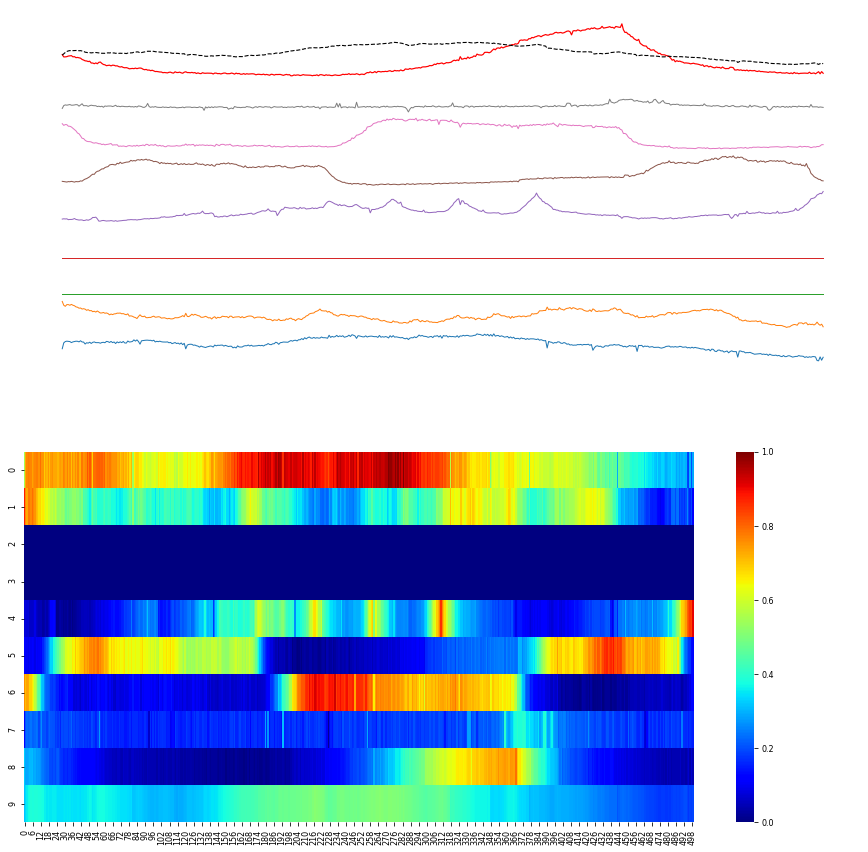

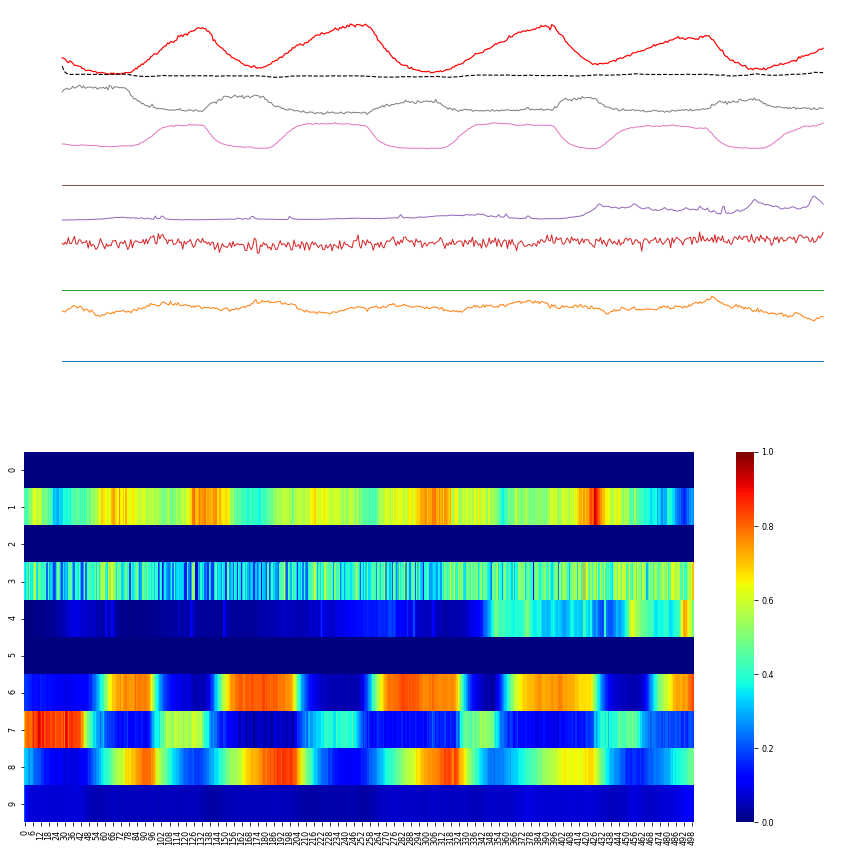

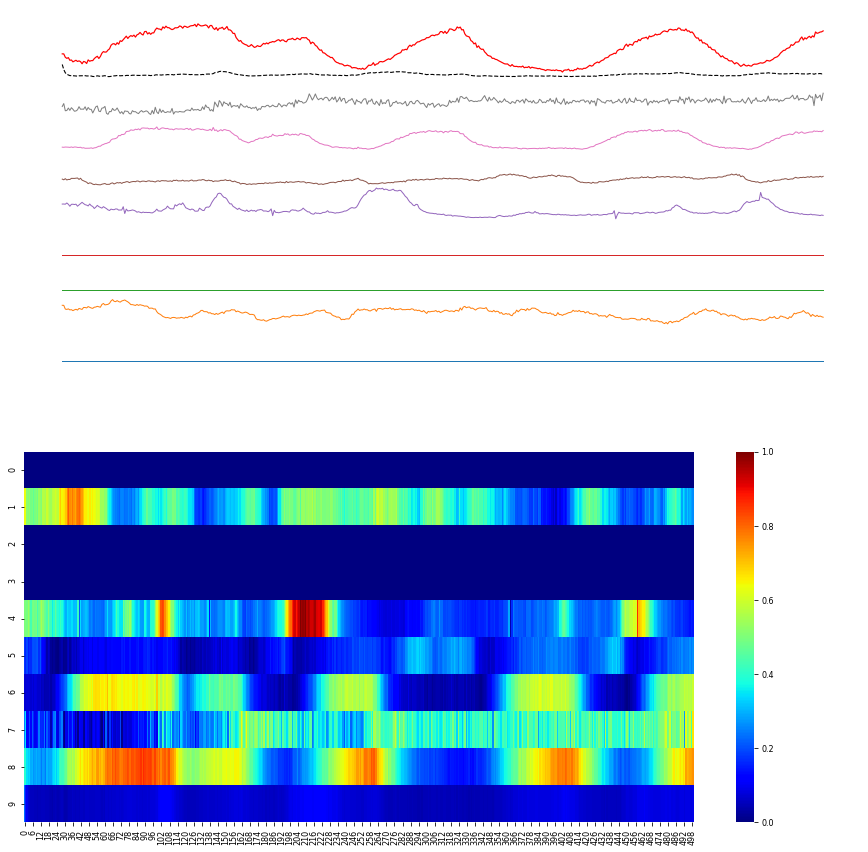

  2%|▏         | 11/701 [01:00<1:17:32,  6.74s/it]

Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  2%|▏         | 12/701 [01:04<1:08:08,  5.93s/it]

215.23976 97.85379
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


  2%|▏         | 13/701 [01:09<1:01:59,  5.41s/it]

214.48654 97.49829
Initial states shape :  torch.Size([1, 6, 9, 1]) Input current shape :  torch.Size([500])


KeyboardInterrupt: 

In [11]:
'''Optimize'''

from tqdm import tqdm
import seaborn as sns
from odynn import optim
import pickle

target = torch.Tensor(traces[:500, None, :, :, None])
init = target[0]
vmask = torch.zeros((1,1,target.shape[-2],1))
vmask[:,:,-1] = 1
vadd = target.clone()
vadd[:,:,:,-1] = 0
print(init.shape, target.shape)

"""Optimize out neuron"""
circuit = get_circ(N_PARALLEL)
circuit._synapses._param['E'] = torch.Tensor(np.repeat(correlations, N_PARALLEL, axis=-1))
circuit._synapses._param['E'].requires_grad = True

def load_param(name='params%s' % NEURON):
    with open(name, 'rb') as f:
        p = pickle.load(f)
    for sub in [circuit._neurons, circuit._synapses, circuit._gaps]:
        for n in sub._parameter_names:
            sub._param[n] = torch.Tensor(p[n])
            sub._param[n].requires_grad = True
# load_param()

ALIGN = [1.1*n for n in range(target.shape[-2])]
def plots(y, traces, loss):
    for i in range(len(recs)):
        plt.figure(figsize=(15,15))
        best = loss.argmin()
        plt.subplot(211)
        plt.plot(traces[:,0,i,:-1,0].detach().numpy() + ALIGN[:-1], linewidth=1)
        plt.plot(2*traces[:,0,i,-1,0].detach().numpy() + ALIGN[-1], linewidth=1.2, color='r')
        plt.plot(2*y[:,0,i,-1,best].detach().numpy() + ALIGN[-1], linewidth=1.1, linestyle='--', color='k')
        plt.xticks(ALIGN, inputs+[NEURON])
        plt.axis('off')
        plt.subplot(212)
        best_cat = torch.cat( (traces[:,0,i,:,0],y[:,0,i,-1:,best]), dim=1 ).detach().numpy().T
        sns.heatmap(best_cat, cmap='jet', vmin=0, vmax=1)
        plt.show()
        plt.close()
    
losses = []
params = [v for v in circuit.parameters.values()]
optimizer = torch.optim.Adam(params, lr=0.001)

for t in tqdm(range(701)):
    y = circuit.calculate(torch.zeros(target.shape[0]), init, vmask=vmask, vadd=vadd)

    loss = optim.loss_mse(y, target)

    losses.append(loss.detach().numpy())
    # Upgrade variables
    optimizer.zero_grad()
    loss.mean().backward()
    for v in circuit._neurons.parameters.values():
        v.grad.data[:-1].zero_()
        
    optimizer.step()

    circuit.apply_constraints()
    
    print(loss.mean().detach().numpy(), loss.min().detach().numpy())

    if t%10 == 0:
        plots(y, target, loss)
        if loss.min() <= losses[-1].min():
            with open('paramspip', 'wb') as f:
                p = {k: v.detach().numpy() for k,v in circuit.parameters.items()}
                pickle.dump(p, f)
                
        

plt.plot([l for l in losses], linewidth=0.2)
plt.yscale('log')
plt.show()

In [12]:
import multiprocessing

multiprocessing.cpu_count()

8